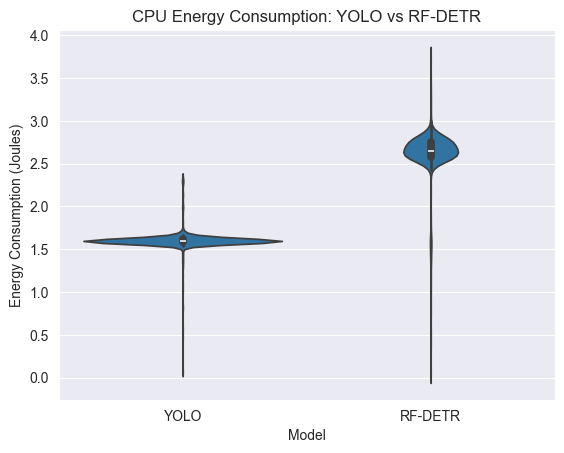

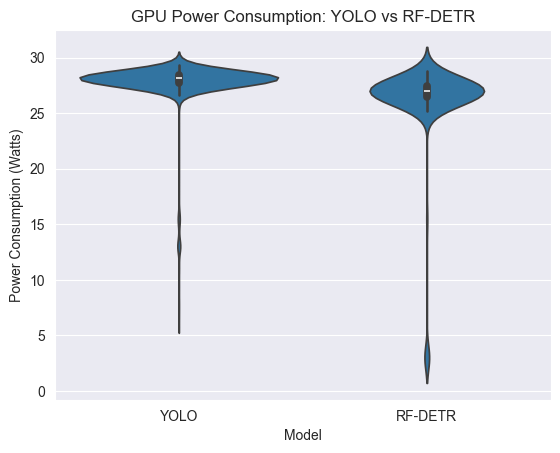

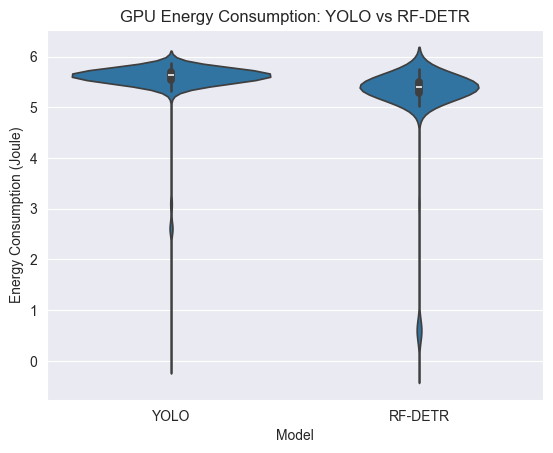

In [34]:
# uncomment + run if they aren't installed already
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_and_box(yolo, detr, y_axis, y_label, title):

    data = pd.DataFrame({
        y_axis: np.concatenate([yolo.values.flatten(), detr.values.flatten()]),
        'Model': ['YOLO']*len(yolo) + ['DETR']*len(detr)
    })
    
    # Violin + Box plots
    sns.violinplot(data=data, x='Model', y=y_axis, inner='box')
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()
    
df_yolo = pd.read_csv("../experiment/results/yolo_run1.csv")
df_detr = pd.read_csv("../experiment/results/rfdet_run1.csv")

# convert power to Watts
y_gpu_power = df_yolo['GPU0_POWER (mWatts)'] / 1000
d_gpu_power = df_detr['GPU0_POWER (mWatts)'] / 1000

# compute time interval between measurements (in seconds)
y_time_delta = df_yolo['Time'].diff() / 1000
d_time_delta = df_detr['Time'].diff() / 1000

# compute energy (E = P * t)
y_gpu_energy = y_gpu_power * y_time_delta
d_gpu_energy = d_gpu_power * d_time_delta

# print(df_yolo['PP0_ENERGY (J)'].values[0:10])

# monotonic counter, should compute the instant energy between time frames
y_cpu_energy = df_yolo['PP0_ENERGY (J)'].diff()
d_cpu_energy = df_detr['PP0_ENERGY (J)'].diff()

# print(y_gpu_power.values[0:10])
# print(y_cpu_energy.values[0:10])

labels = ['YOLO', 'RF-DETR']

plot_violin_and_box(y_cpu_energy, d_cpu_energy, 'Energy', 'Energy Consumption (Joules)', 'CPU Energy Consumption: YOLO vs RF-DETR')

plot_violin_and_box(y_gpu_power, d_gpu_power, 'Power', 'Power Consumption (Watts)', 'GPU Power Consumption: YOLO vs RF-DETR')

plot_violin_and_box(y_gpu_energy, d_gpu_energy, 'Energy', 'Energy Consumption (Joule)', 'GPU Energy Consumption: YOLO vs RF-DETR')

PRELIMINARY:
- CPU usage: YOLO seems to consume less energy.
- GPU usage: RF-DETR seems to consume less power.

In [41]:
# !pip install scipy

from scipy.stats import ttest_ind, shapiro, mannwhitneyu

# if data is not normal (see the violin plots), then we need other tests / procedures

def statistical_tests(y, d):
    
    # Shapiro-Wilk test (testing normality)
    shap_yolo = shapiro(y.values)
    shap_detr = shapiro(d.values)
    
    # Statistical significance tests depending on normality
    if shap_yolo.pvalue < 0.05 or shap_detr.pvalue < 0.05:
        print("Some dataset is NOT normally distributed.")
        
        # Statistical significance test
        print('Statistical significance test')
        
        # null hypothesis: distribution of yolo is the same as rf-detr
        # if p_values < 0.05, then we can assume different distributions
        mwu = mannwhitneyu(y.values, d.values)
        print(f'\tMann-Whitney U test: '
              f'\n\t\t{mwu.statistic} '
              f'\n\t\t{mwu.pvalue}')
        
        print('Effect size analysis')
        
        median_yolo = np.median(y.values)
        median_detr = np.median(d.values)
        median_difference = median_yolo - median_detr
        
        cles = mwu.statistic / (len(y.values) * len(d.values))
        
        print(f'\tMedian difference: {median_difference:.2f}')
        print(f'\tCommon language effect size: {cles:.2f}')
    
    else:    
        print("Normal distribution can be assumed.")
        
        # Statistical significance test (Welch's t-test)
        _,welch_pvalue = ttest_ind(
            y.values, d, equal_var=False, alternative='two-sided')
        
        print('\nStatistical significance test')
        if welch_pvalue < 0.05:
            print(f'\tP-value is significant ({welch_pvalue[0]})')
        else:
            print(f'\tP-value is not significant ({welch_pvalue[0]})')
            
        print('\nEffect size analysis')
        
        # using "raw" difference to retain more information
        mean_diff = y.values.mean() - d.values.mean()
        percentage_change = (mean_diff / y.values.mean()) * 100
        cohen_d = mean_diff / (0.5 * np.sqrt(np.square(y.values.std()) + np.square(d.values.std())))
        
        print(f'\tMean difference: {mean_diff:.2f}')
        print(f'\tPercentage change: {percentage_change:.2f}')
        print(f'\tCohen\'s Difference: {cohen_d:.2f}')
   
print('GPU power consumption')     
statistical_tests(y_gpu_power, d_gpu_power)
print('-------')
print('GPU energy consumption')
statistical_tests(y_gpu_energy, d_gpu_energy)

GPU power consumption
Some dataset is NOT normally distributed.
Statistical significance test
	Mann-Whitney U test: 
		1166709.0 
		1.7652747441190182e-226
Effect size analysis
	Median difference: 1.15
	Common language effect size: 0.89
-------
GPU energy consumption
Normal distribution can be assumed.

Statistical significance test


IndexError: invalid index to scalar variable.

PRELIMINARY GPU power consumption: 
- RF_DETR consumes less power on average, while YOLO is consistently consuming more.
- In 89% of the time, YOLO will have higher power consumption than RF-DETR. 
- The median difference of 1.15 shows that YOLO's power consumption lies generally higher than RF-DETR's.

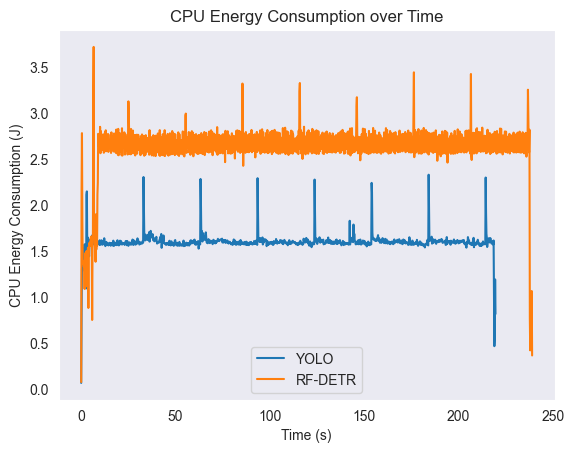

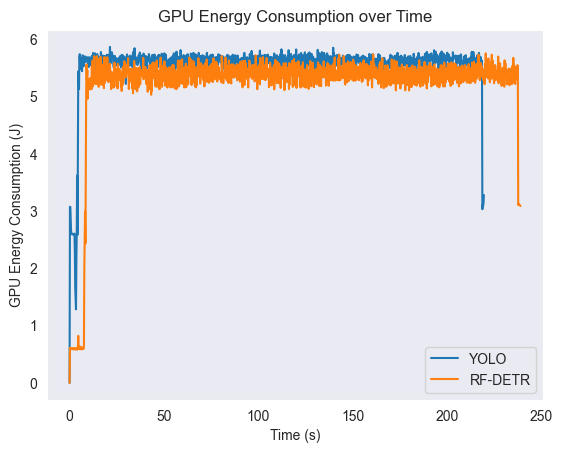

In [37]:
# Nvidia GPU label: GPU0_POWER (mWatts)

# CPU 
y_time = df_yolo['Time'] - df_yolo['Time'].iloc[0]
d_time = df_detr['Time'] - df_detr['Time'].iloc[0]

plt.plot(y_time / 1000, y_cpu_energy.values, label='YOLO')
plt.plot(d_time / 1000, d_cpu_energy.values, label='RF-DETR')

plt.xlabel('Time (s)')
plt.ylabel('CPU Energy Consumption (J)')
plt.title('CPU Energy Consumption over Time')
plt.legend()
plt.grid()
plt.show()

# GPU power -> energy

# y_gpu_energy = np.trapz(y_gpu_power, y_time / 1000)
# d_gpu_energy = np.trapz(d_gpu_power, d_time / 1000)

plt.plot(y_time / 1000, y_gpu_energy.values, label='YOLO')
plt.plot(d_time / 1000, d_gpu_energy.values, label='RF-DETR')

plt.xlabel('Time (s)')
plt.ylabel('GPU Energy Consumption (J)')
plt.title('GPU Energy Consumption over Time')
plt.legend()
plt.grid()
plt.show()